In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from utils import get_model
import torch

weight_dir = 'model.pt'
model = get_model(weight_dir, n_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


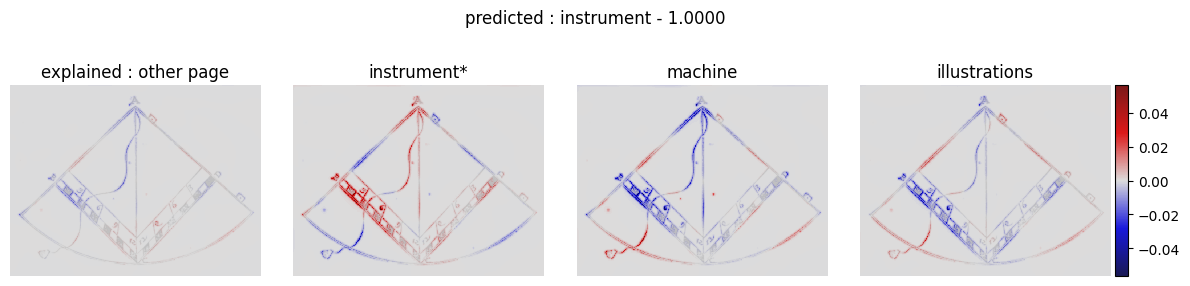

In [3]:
from dataloaders.proc_utils import read_image_gray, binarize, write_image_binary

file_name= '2255_fine_opere_1587_p249.jpg'
book_dir = 'sample_data/1_instrument/2255_fine_opere_1587/'
proc_dir = os.path.join(book_dir, 'processed')
raw_dir = os.path.join(book_dir, 'raw')

file_path_bin = os.path.join(proc_dir, file_name)

# Binarize
if not os.path.exists(file_path_bin):
    image = read_image_gray(os.path.join(raw_dir, file_name))
    image = binarize(image)
    write_image_binary(file_path_bin, image)


# Load
from dataloaders.instrument_pages import sphaera_instruments_page
from dataloaders.dataset import PageDataset, PageDatasetBoxes

data_root = 'sample_data/1_instrument'
csv_instruments = 'sample_data/instrument_sample.csv'
df_instruments = pd.read_csv(csv_instruments)
df_instruments['label'] = [1]*len(df_instruments)

# Collecting data
dataloader = sphaera_instruments_page(data_root=data_root, source=df_instruments, binarize=False, refsize=800, removemean=True, train_split=0., extra_data = None, loader = PageDatasetBoxes )  



# Get and explain predictions
from xai import explain, get_prediction, plot_heatmap

title_map = {0: 'other page', 1: 'instrument', 2: 'machine', 3: 'illustrations'}

j=0
for x in dataloader['train']:

    y_pred, logits, probs =  get_prediction(model, x[0], device)
    cases = [i for i in sorted(title_map.keys())]
    y_true = int(x[2][j])
    confidence = '{:0.4f}'.format(probs[y_true])

    R_dict = {k: None for k in cases}

    for l,cl  in enumerate(cases):

        R_ = explain(model, x[0].to(device), cl=cl, device=device, n_classes=len(title_map))
        R = np.array(R_[0][0].detach().cpu().numpy()).sum(axis=0)
        R_dict[cl] = R

    f, axs = plt.subplots(1,len(title_map), figsize=(12.,3.5))
    b = np.max([10*((np.abs(R)**3.0).mean()**(1.0/3)) for R in R_dict.values()])
    for l, cl in enumerate(cases):
        title_map_ = {k:v for k,v in title_map.items()}
        title_map_[y_true] += '*'
        plot_heatmap(R_dict[cl], x[0].squeeze()[0], (f,axs[l]), l, title_map_, cl, b)

    f.tight_layout()
    f.suptitle('predicted : {} - {:0.4f}'.format(title_map[y_pred], probs[y_pred]), y=0.99) #0.91)
    plt.show()

